# Modelling an asymptotic approximation

With `asterion.AsyModel`, you can model the helium-II ionization and base of the convective zone glitches given radial mode frequencies. This can be done with modelled or observed modes (with and without observational uncertainty). This notebook will go through both situations.

In [1]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

from asterion.models import AsyModel
from asterion.inference import Inference
from asterion.data import save

from corner import corner

## Data

Import stellar evolutionary track.

In [2]:
track = pd.read_csv('data/modes.csv')
track.head()

,frac_age,delta_nu_fit,nu_max,nu_0_1,nu_0_2,nu_0_3,nu_0_4,nu_0_5,nu_0_6,nu_0_7,...,nu_0_32,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,surface_he4
0,0.000016,11.884045,150.680452,0.0,34.481794,49.329712,63.195077,75.913367,87.630758,99.483102,...,392.064627,403.710370,415.297909,426.924218,438.655667,450.550178,462.546781,474.658899,486.825847,0.239966
1,0.000017,12.140476,154.893200,0.0,35.203007,50.376320,64.548471,77.583389,89.569246,101.679667,...,400.620086,412.538305,424.386957,436.252351,448.212638,460.326691,472.558635,484.919720,497.325734,0.239967
2,0.000017,12.343045,158.238356,0.0,35.772049,51.202159,65.616199,78.900744,91.100159,103.413323,...,407.368711,419.505074,431.563921,443.619056,455.762984,468.048949,480.469626,493.018551,505.616340,0.239968
3,0.000018,12.503403,160.898485,0.0,36.222266,51.855582,66.460893,79.942765,92.312228,104.785371,...,412.708426,425.019262,437.245702,449.452226,461.742276,474.164224,486.734715,499.427290,512.179364,0.239969
4,0.000018,12.633487,163.061612,0.0,36.587368,52.385499,67.145867,80.787635,93.295718,105.898357,...,417.037759,429.491253,441.854064,454.184875,466.594022,479.127384,491.819429,504.626946,517.505773,0.239969


Choose a star from the evolutionary track.

In [3]:
profile = track.loc[600]

Extract modes from star.

In [4]:
n = np.arange(10, 30)
nu_index = [f'nu_0_{i}' for i in n]

def get_nu(profile):
    nu = profile[nu_index].to_numpy().astype(float)
    nu = nu[nu > 0.0]  # Values equal to zero correspond to no calculation
    return nu

nu = get_nu(profile)

Get global asteroseismic parameters.

In [5]:
# Scaling relation nu_max
nu_max_sca = profile['nu_max']
print('nu_max ~', round(nu_max_sca, 2), 'muHz')

# Delta_nu fit to radial modes about nu_max
delta_nu_fit = profile['delta_nu_fit']
print('delta_nu ~', round(delta_nu_fit, 2), 'muHz')

nu_max ~ 2853.19 muHz
delta_nu ~ 128.7 muHz


## Model without observational error

We can create our model like this. We need to give it a prior for `delta_nu` and `nu_max`. Optionally, we can give it a prior for asymptotic fit parameters `alpha` and `epsilon`, but by default these are fairly uninformative.

In [6]:
delta_nu = [delta_nu_fit, 1.0]
nu_max = [nu_max_sca, 0.05*nu_max_sca]

In [7]:
model = AsyModel('model_star', delta_nu, nu_max, nu=nu, n=n, 
                 regularization=1e-6)

### Inference

We setup an inference class with the model and can give it number of warmup steps and samples. The seed is required for reproducibility.

In [8]:
infer = Inference(model, num_warmup=2000, num_samples=2000, seed=42)

#### Prior predictive check

We should do a prior predictive check to see if our model makes sense.

In [9]:
infer.prior_predictive()

This plot shows the prior for `nu` with the dot representing the observed value. It looks good.

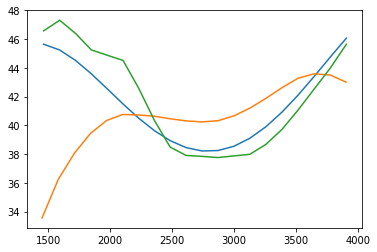

In [10]:
epsilon = 1.29
alpha = 2e-3
n_max = nu_max[0] / delta_nu[0] - epsilon
a0 = delta_nu[0] * (epsilon + 0.5 * alpha * n_max**2)
a1 = delta_nu[0] * (1 - alpha * n_max)
a2 = delta_nu[0] * 0.5 * alpha
a3 = 1e-4
a4 = -5e-4
nu_asy = a0 + a1 * n + a2 * n**2 + a3 * n**3 + a4 * (n-n_max)**4

plt.plot(nu_asy, nu_asy%delta_nu[0])

nu_med = infer.data.prior_predictive['nu'].sel(name='model_star').median(dim=['chain', 'draw'])
plt.plot(nu_med, nu_med%delta_nu[0])
plt.plot(nu, nu%delta_nu[0])

In [11]:
var_names = ['delta_nu', 'nu_max', 'epsilon', 'alpha', 
             'beta', 'gamma', 'err']

In [12]:
infer.data

Inference data with groups:
	> prior_predictive
	> observed_data
	> constant_data

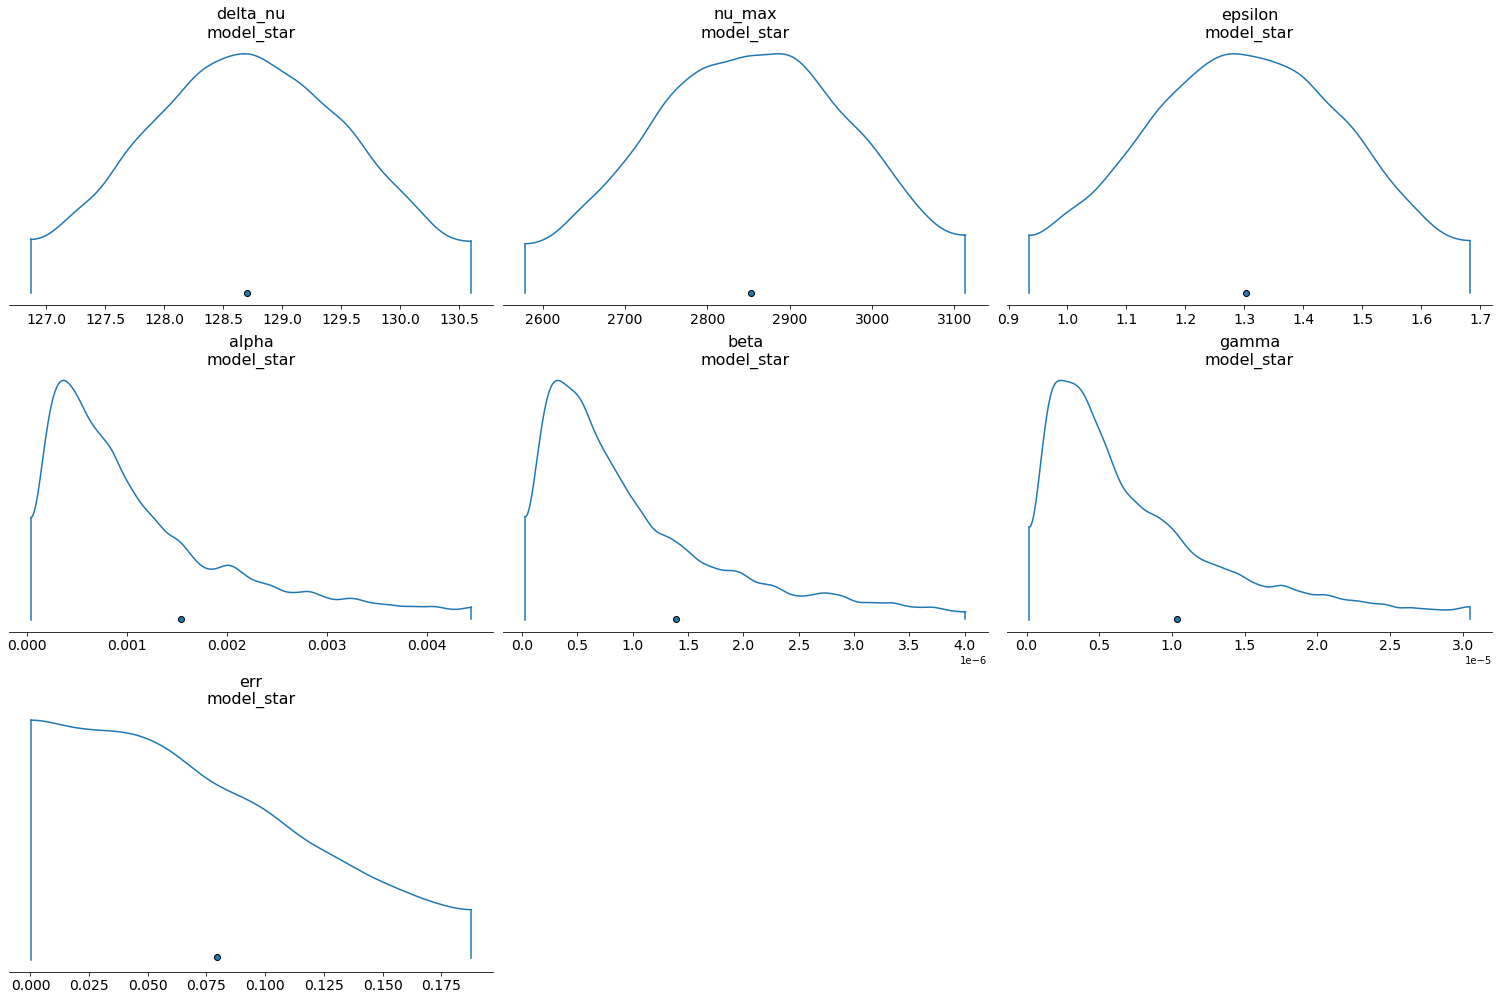

In [13]:
az.plot_density(infer.data, var_names=var_names, group='prior_predictive');

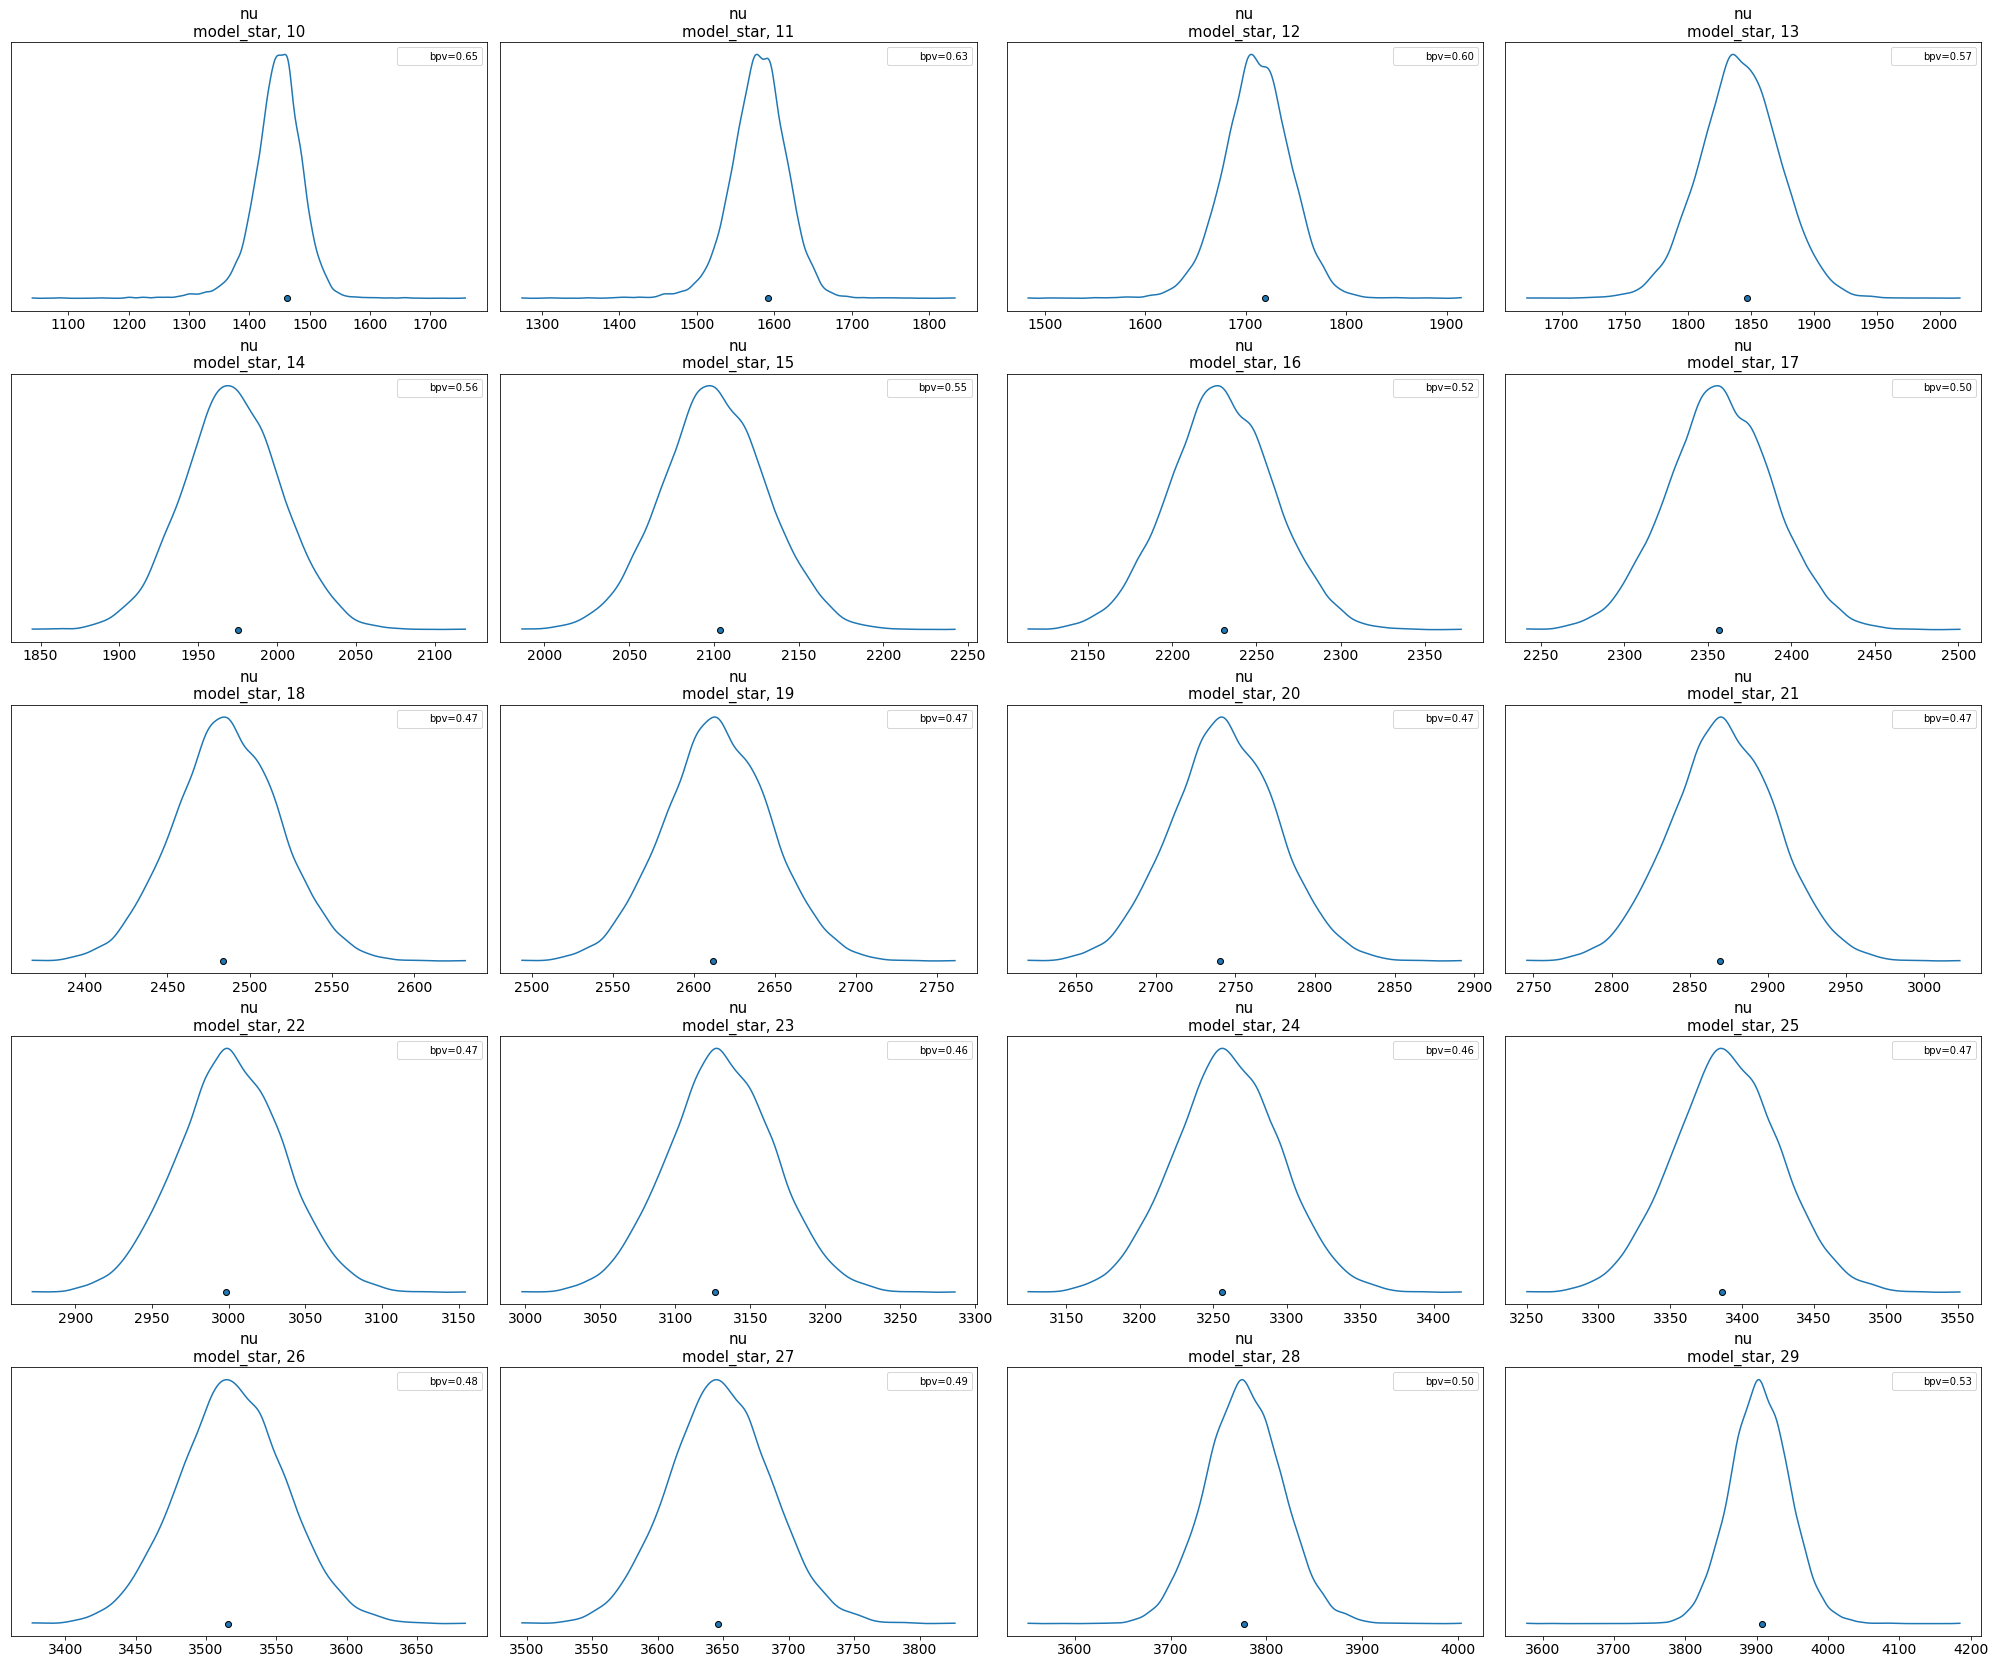

In [14]:
az.plot_bpv(infer.data, var_names=['nu'], group='prior', kind='t_stat', flatten=['chain', 'draws']);

#### Sample posterior

We sample from the posterior using the `numpyro` NUTS sampler. This should take about a minute.

In [15]:
infer.sample()

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Lets have a look at the trace plot for the model parameters.

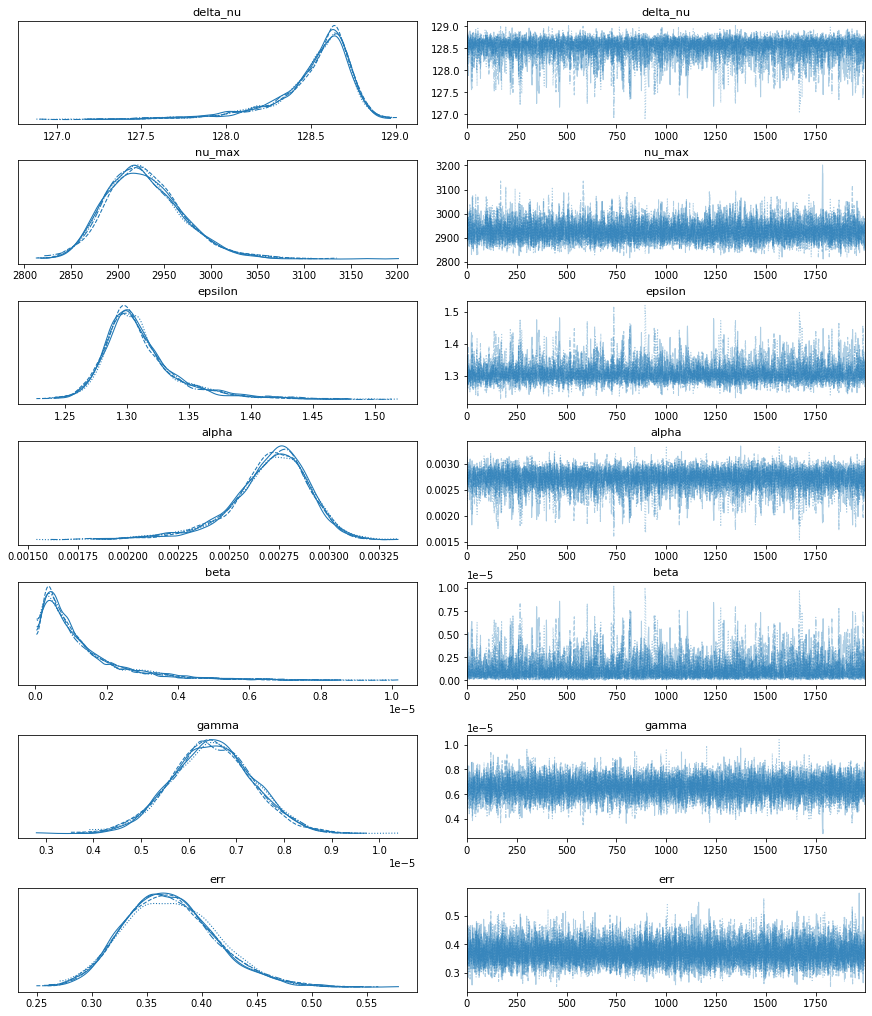

In [16]:
az.plot_trace(infer.data, var_names=var_names);

The data works with the `corner` module too.

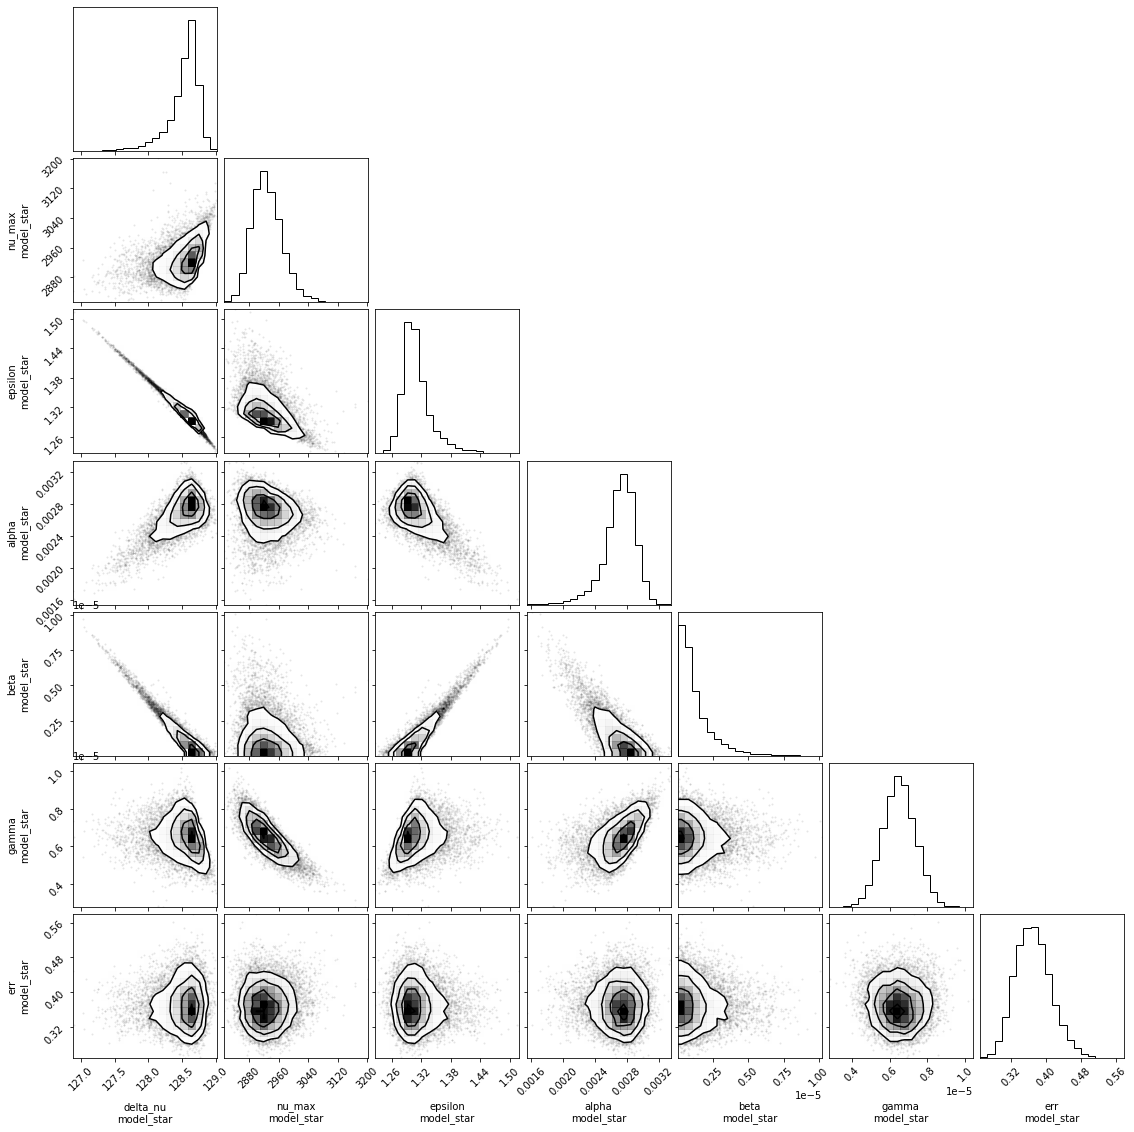

In [17]:
corner(
    infer.data, 
    var_names=var_names, 
    divergences=True,
    divergences_kwargs={'color': 'r', 'alpha': 0.9, 'markersize': 4}
);

#### Posterior predictive check

Finally, we do a posterior predictive check to see if our results make sense.

In [18]:
infer.posterior_predictive()

The dots are the observed values and the curves are the posterior estimates. Looks pretty good.

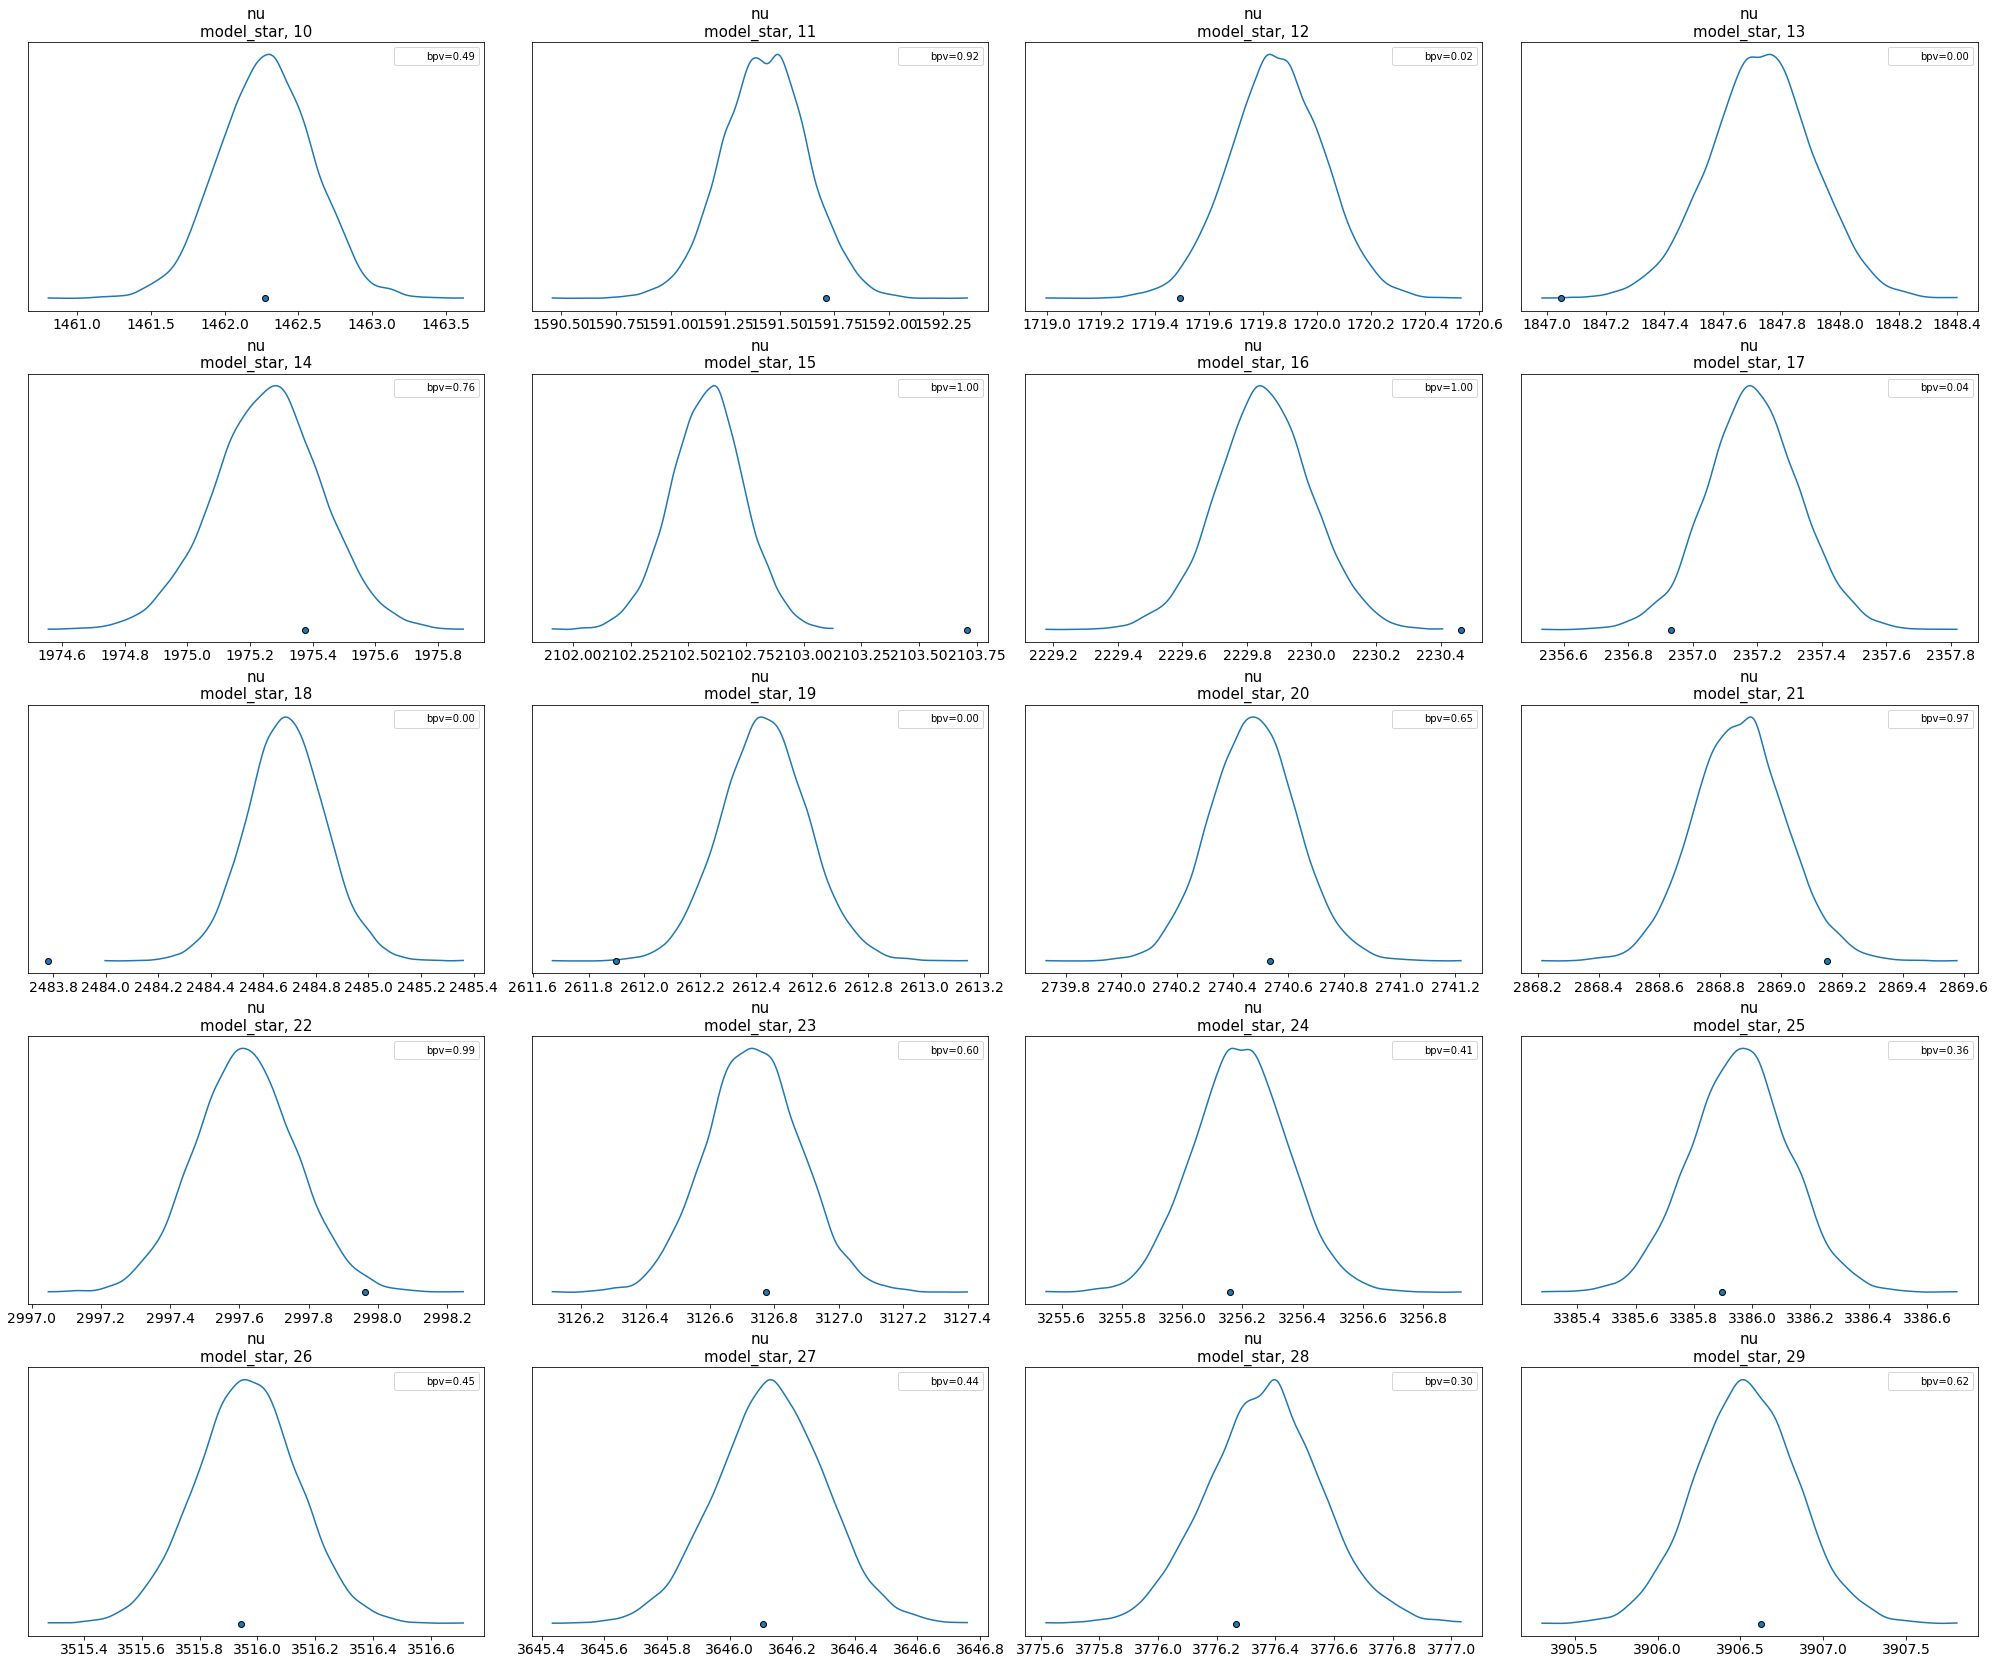

In [19]:
az.plot_bpv(infer.data, var_names=['nu'], group='posterior', kind='t_stat', flatten=['chain', 'draws']);

Let's check whether our model parameters are prior dominated by comparing the prior_predictive to the posterior

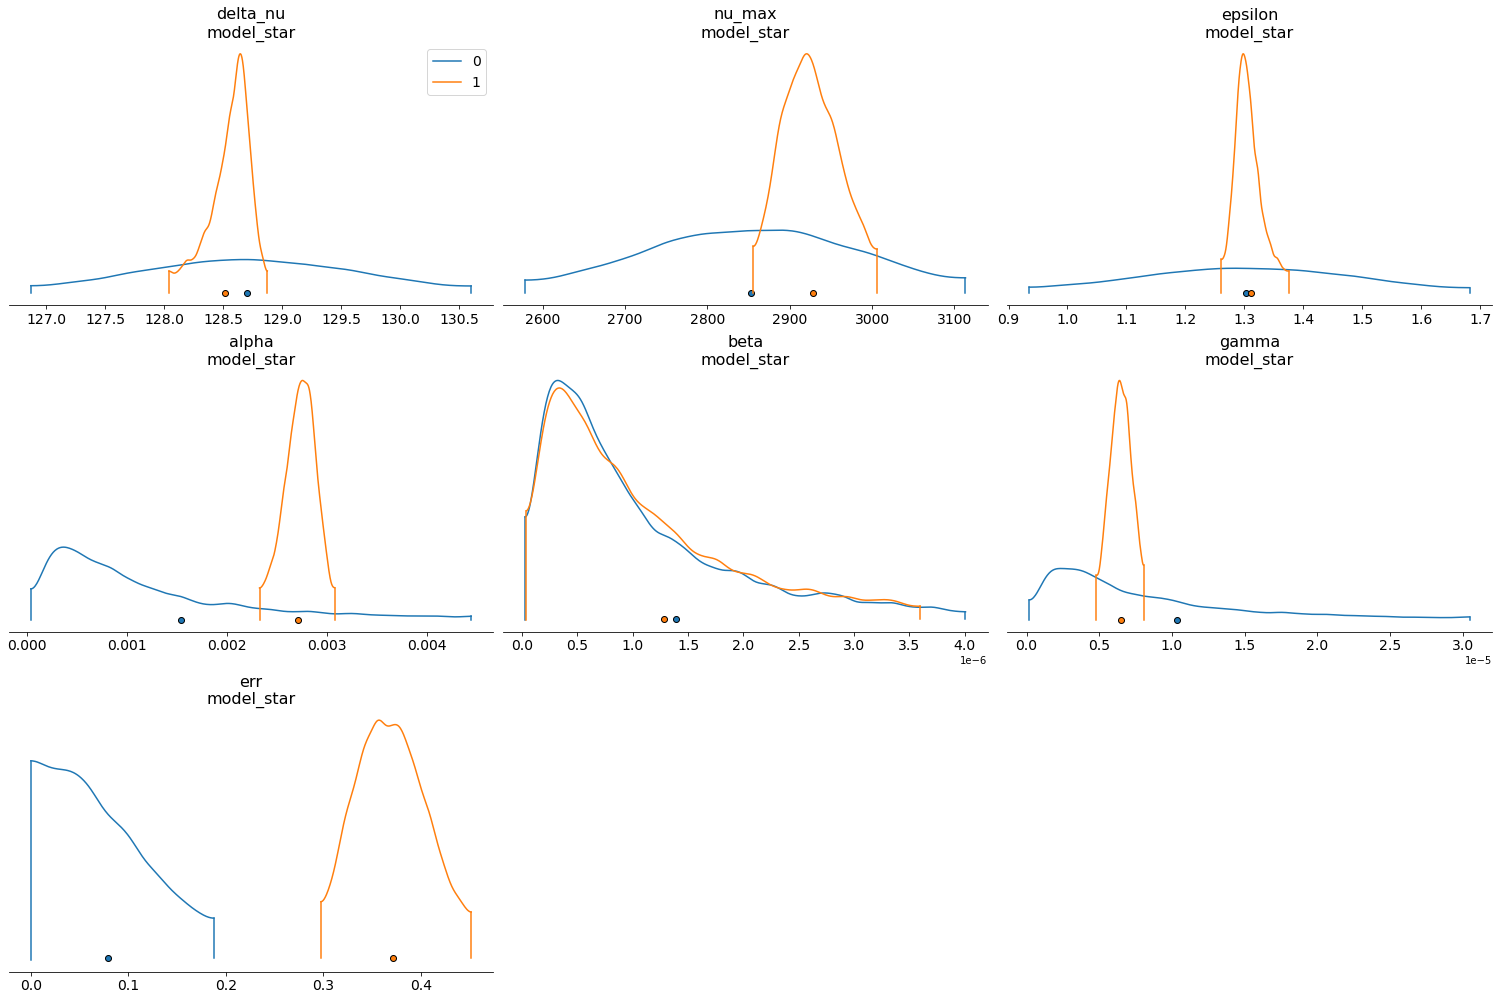

In [20]:
az.plot_density([infer.data.prior_predictive, infer.data.posterior], var_names=var_names);

#### Predictions

Finally, let's make some predictions from our posterior samples. This will be a continuous function of `n`.

In [21]:
infer.predictions()

We can view our inference data interactively.

In [22]:
infer.data

Inference data with groups:
	> posterior
	> posterior_predictive
	> predictions
	> sample_stats
	> prior_predictive
	> observed_data
	> constant_data

Let's look at the predictions.

In [23]:
post = infer.data.posterior

In [24]:
pred = infer.data.predictions

In [25]:
obs = infer.data.observed_data

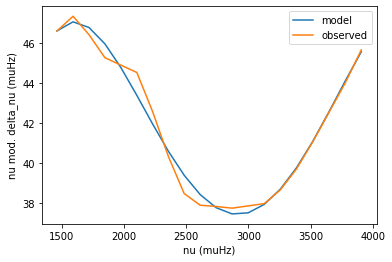

In [26]:
dim = ["chain", "draw"]  # Dimensions to calculate stats over
name = "model_star"      # Name of star to plot

# plt.errorbar(
#     glitch_obs["n"],
#     glitch_obs_med,
#     yerr=[
#         glitch_obs_med-lower,
#         upper-glitch_obs_med,
#     ],
#     fmt='.',
#     label=r'$\nu_\mathrm{obs} - \nu_\mathrm{asy}$',
# )

nu_med = post["nu"].sel(name=name).median(dim=dim)
plt.plot(
    nu_med, 
    nu_med%delta_nu[0],
    label='model'
)

plt.plot(
    nu, 
    nu%delta_nu[0],
    label='observed'
)

# plt.fill_between(
#     glitch_pred["n_pred"], 
#     glitch_pred.sel(name=name).quantile(.16, dim=dim),
#     glitch_pred.sel(name=name).quantile(.84, dim=dim),
#     alpha=0.5,
#     color='C1',
#     label='credible interval',
# )

plt.xlabel('nu (muHz)')
plt.ylabel('nu mod. delta_nu (muHz)')
plt.legend();

In [27]:
nu_asy = post['nu_asy']
nu_asy_pred = pred['nu_asy']

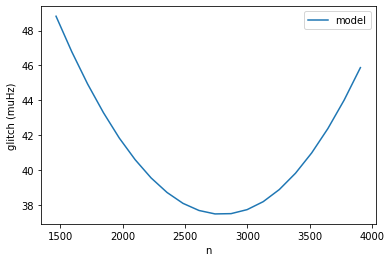

In [28]:
dim = ["chain", "draw"]  # Dimensions to calculate stats over
name = "model_star"      # Name of star to plot

glitch_med = glitch.sel(name=name).median(dim=dim)
glitch_obs_med = glitch_obs.sel(name=name).median(dim=dim)
upper = glitch_obs.sel(name=name).quantile(.84, dim=dim)
lower = glitch_obs.sel(name=name).quantile(.16, dim=dim)

# plt.errorbar(
#     glitch_obs["n"],
#     glitch_obs_med,
#     yerr=[
#         glitch_obs_med-lower,
#         upper-glitch_obs_med,
#     ],
#     fmt='.',
#     label=r'$\nu_\mathrm{obs} - \nu_\mathrm{asy}$',
# )

plt.plot(
    nu_asy.sel(name=name).median(dim=dim), 
    nu_asy.sel(name=name).median(dim=dim)%delta_nu[0],
    label='model'
)
# plt.fill_between(
#     glitch_pred["n_pred"], 
#     glitch_pred.sel(name=name).quantile(.16, dim=dim),
#     glitch_pred.sel(name=name).quantile(.84, dim=dim),
#     alpha=0.5,
#     color='C1',
#     label='credible interval',
# )

plt.xlabel('n')
plt.ylabel('glitch (muHz)')
plt.legend();

In [32]:
save(infer.data, 'example.trace')

'example.trace'

## Model with observational error

Synthesise observational error.

In [33]:
nu_err = 1e-6 * (nu - nu_max_sca)**2

In [34]:
rng = np.random.default_rng(42)

In [35]:
def add_noise(rng, nu, nu_err):
    return rng.normal(nu, nu_err)

In [36]:
nu_obs = add_noise(rng, nu, nu_err)

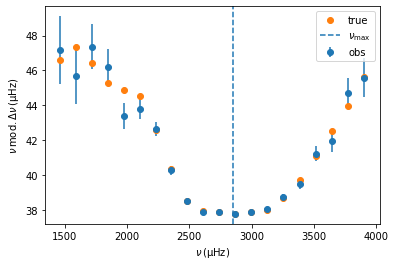

In [37]:
nu_mod = nu % delta_nu_fit
nu_mod_obs = nu_obs % delta_nu_fit

fig, ax = plt.subplots()

ax.errorbar(nu_obs, nu_mod_obs, yerr=nu_err, fmt='o', label='obs')
ax.plot(nu, nu_mod, 'o', label='true')

ax.axvline(nu_max_sca, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [38]:
model = GlitchModel('obs_star', delta_nu, nu_max, nu=nu_obs, nu_err=nu_err, n=n)

### Inference

We setup an inference class with the model and can give it number of warmup steps and samples. The seed is required for reproducibility.

In [39]:
infer = Inference(model, num_warmup=2000, num_samples=2000, seed=42)

#### Prior predictive check

We should do a prior predictive check to see if our model makes sense.

In [40]:
infer.prior_predictive()

You may do the same plots as before.

In [41]:
infer.sample()

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [42]:
infer.posterior_predictive()

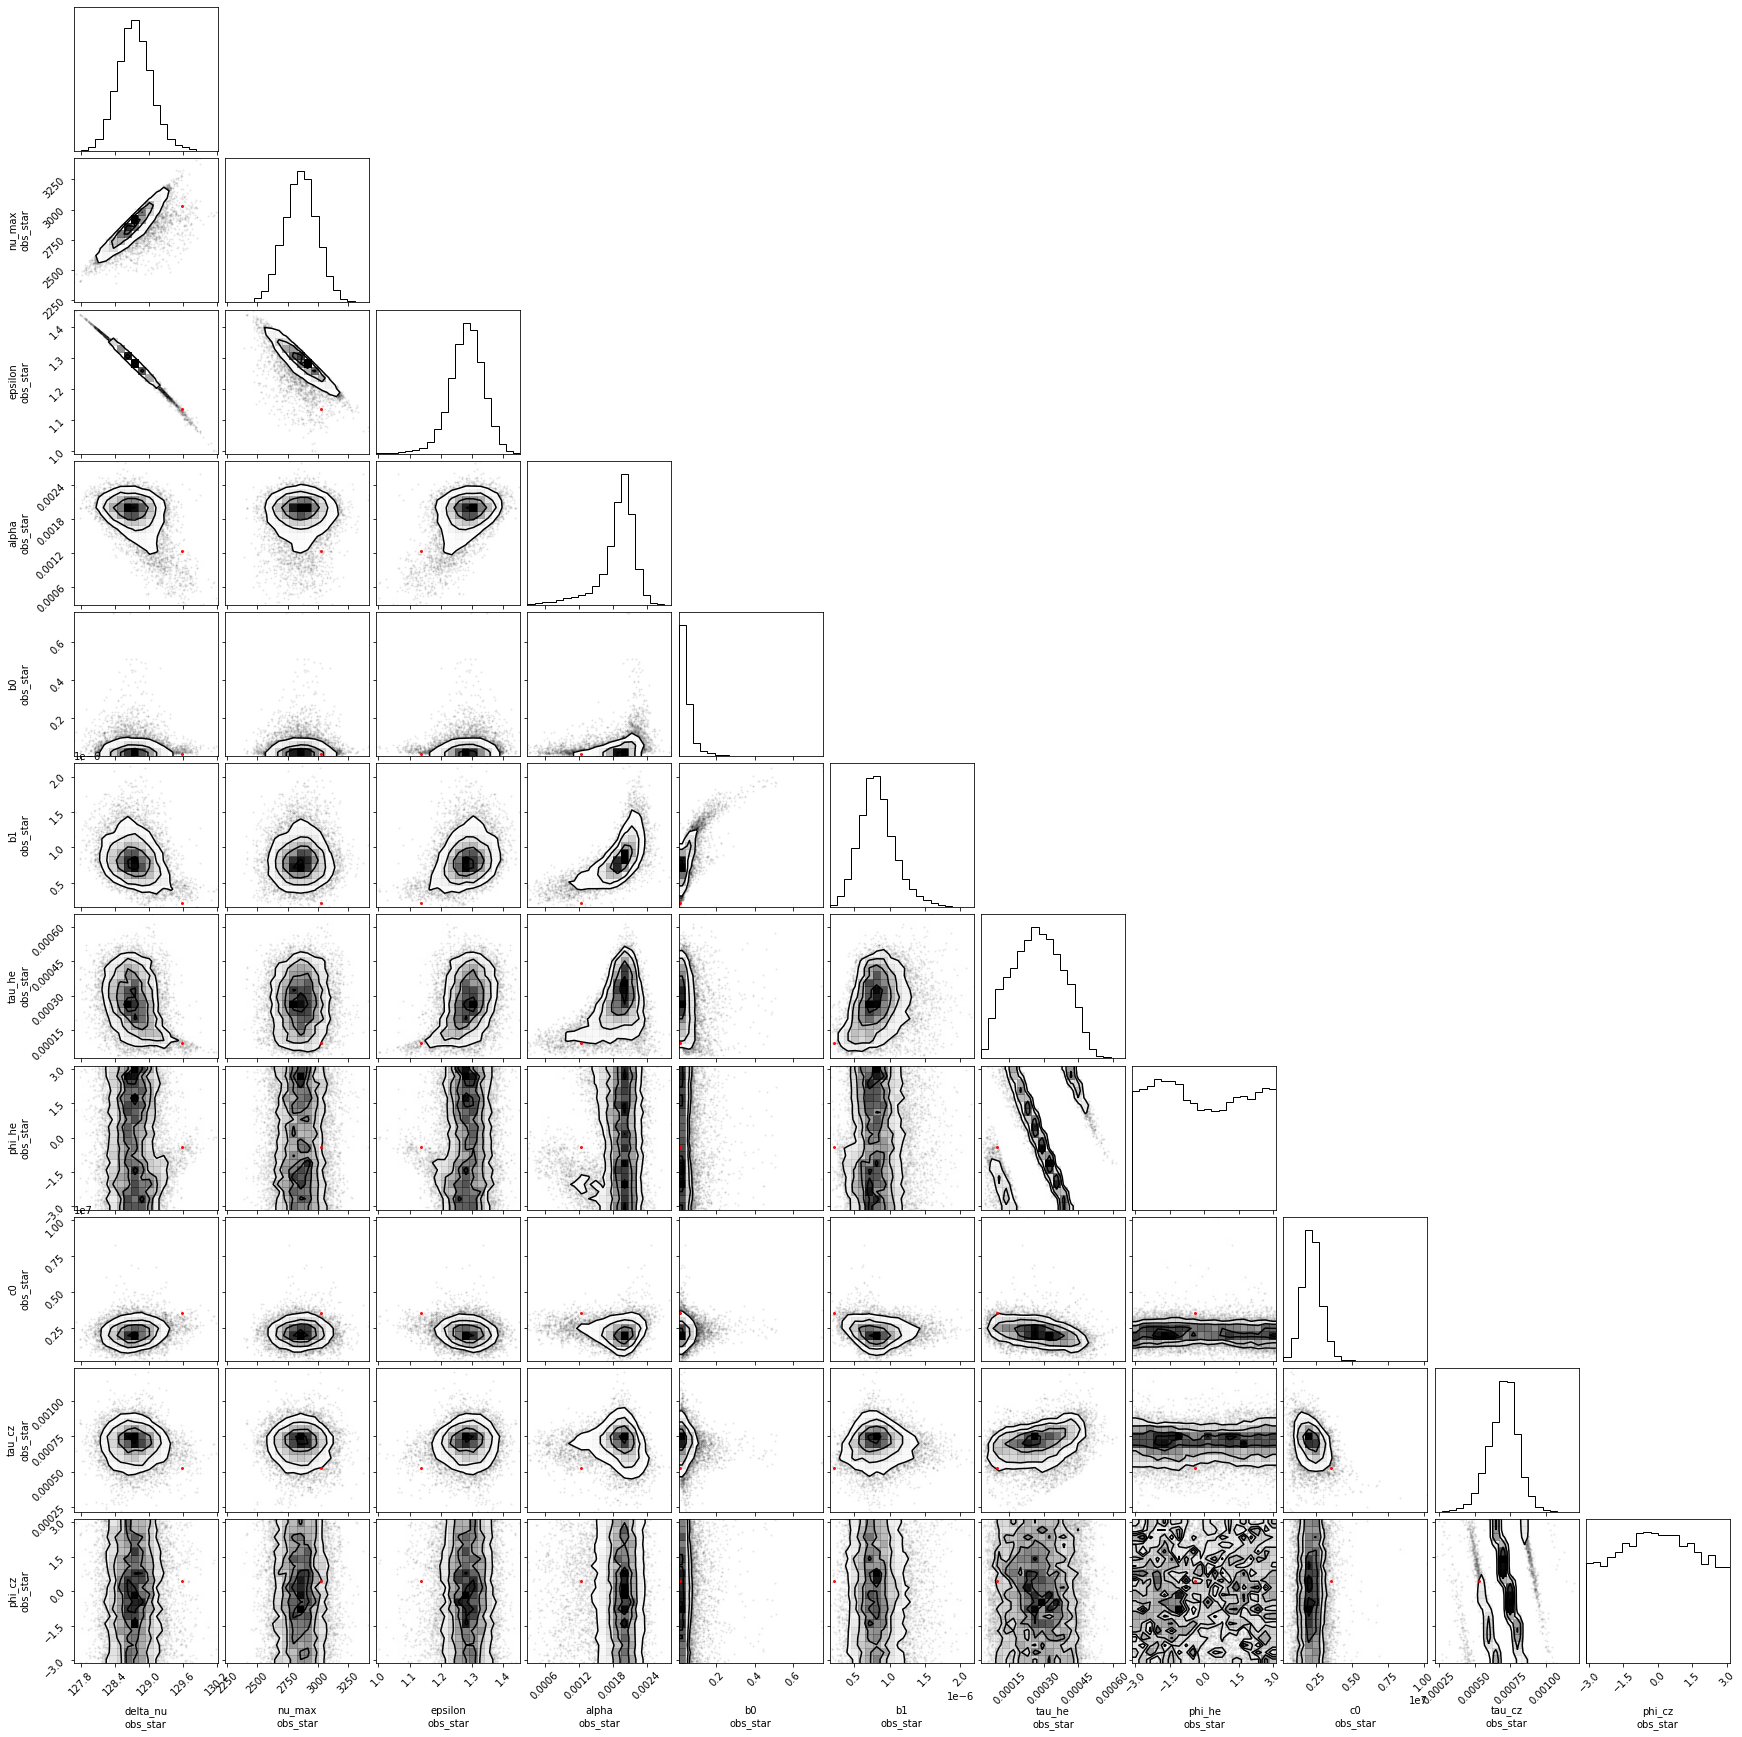

In [43]:
corner(
    infer.data, 
    var_names=var_names, 
    divergences=True,
    divergences_kwargs={'color': 'r', 'alpha': 0.9, 'markersize': 4}
);

#### Predictions

Finally, let's make some predictions from our posterior samples. This will be a continuous function of `n`.

In [44]:
infer.predictions()

We can view our inference data interactively.

In [45]:
infer.data

Inference data with groups:
	> posterior
	> posterior_predictive
	> predictions
	> sample_stats
	> prior_predictive
	> observed_data
	> constant_data

Let's look at the predictions.

In [46]:
post = infer.data.posterior

In [47]:
pred = infer.data.predictions

In [48]:
obs = infer.data.observed_data

In [49]:
glitch = post["dnu_he"] + post["dnu_cz"]

In [50]:
glitch_obs = obs['nu'] - post['nu_asy']

In [51]:
glitch_pred = pred["dnu_he"] + pred["dnu_cz"]  # Add both glitches

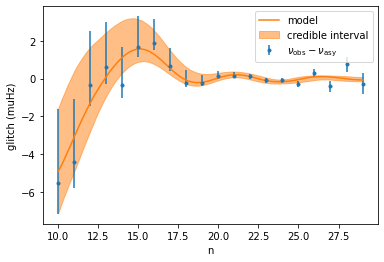

In [52]:
dim = ["chain", "draw"]  # Dimensions to calculate stats over
name = "obs_star"      # Name of star to plot

glitch_med = glitch.sel(name=name).median(dim=dim)
glitch_obs_med = glitch_obs.sel(name=name).median(dim=dim)
upper = glitch_obs.sel(name=name).quantile(.84, dim=dim)
lower = glitch_obs.sel(name=name).quantile(.16, dim=dim)

plt.errorbar(
    glitch_obs["n"],
    glitch_obs_med,
    yerr=[
        glitch_obs_med-lower,
        upper-glitch_obs_med,
    ],
    fmt='.',
    label=r'$\nu_\mathrm{obs} - \nu_\mathrm{asy}$',
)

plt.plot(
    glitch_pred["n_pred"], 
    glitch_pred.sel(name=name).median(dim=dim),
    label='model'
)
plt.fill_between(
    glitch_pred["n_pred"], 
    glitch_pred.sel(name=name).quantile(.16, dim=dim),
    glitch_pred.sel(name=name).quantile(.84, dim=dim),
    alpha=0.5,
    color='C1',
    label='credible interval',
)

plt.xlabel('n')
plt.ylabel('glitch (muHz)')
plt.legend();

In [53]:
save(infer.data, 'example_obs.trace')

'example_obs.trace'